In [1]:
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *
import networkx as nx
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
L = 10
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 
# nx.draw(G, with_labels=True)

In [3]:
from qrisp.operators import X, Y, Z

J = 1
B = 0.5
H = create_heisenberg_hamiltonian(G, J, B)
print(H)

X(0)*X(1) + X(1)*X(2) + X(2)*X(3) + X(3)*X(4) + X(4)*X(5) + X(5)*X(6) + X(6)*X(7) + X(7)*X(8) + X(8)*X(9) + Y(0)*Y(1) + Y(1)*Y(2) + Y(2)*Y(3) + Y(3)*Y(4) + Y(4)*Y(5) + Y(5)*Y(6) + Y(6)*Y(7) + Y(7)*Y(8) + Y(8)*Y(9) + 0.5*Z(0) + Z(0)*Z(1) + 0.5*Z(1) + Z(1)*Z(2) + 0.5*Z(2) + Z(2)*Z(3) + 0.5*Z(3) + Z(3)*Z(4) + 0.5*Z(4) + Z(4)*Z(5) + 0.5*Z(5) + Z(5)*Z(6) + 0.5*Z(6) + Z(6)*Z(7) + 0.5*Z(7) + Z(7)*Z(8) + 0.5*Z(8) + Z(8)*Z(9) + 0.5*Z(9)


In [4]:
eigvals = scipy.sparse.linalg.eigs(H.to_array())
eigvals_from_low = np.sort(eigvals[0])
print(eigvals_from_low)
target = np.real(eigvals_from_low[0])
first_excited = np.real(eigvals_from_low[1])
print('Target energy', target)
print('First excited energy', first_excited)

[-17.03214083-7.61789712e-17j -16.72269436+6.83233791e-17j
 -15.72269436-4.52466908e-17j -15.10817429+1.27502588e-16j
 -14.72269436+2.20983076e-17j -14.10817429-1.23330038e-16j]
Target energy -17.032140829131595
First excited energy -16.722694358006102


In [5]:
vqe = heisenberg_problem(G,J,B, ansatz_type='per hamiltonian')
U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=1,max_iter=20)

qv= QuantumVariable(G.number_of_nodes())
U_0(qv)
E_0 = H.get_measurement(qv,precision=0.01)
print(E_0)

/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Simulating 10 qubits.. |                                                     | [  0%]

/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-16.347151736016514                                                                  


In [6]:
def compute_moments(psi, H):
    E = (psi.conj().T @ H @ psi)[0,0].real
    S = (psi.conj().T @ H @ H @ psi)[0,0].real
    return E, S, S - E**2

In [7]:
psi0 = qv.qs.statevector_array().reshape(-1,1)
# psi0 = np.zeros((2**L, 1))
# psi0[0][0] = 1.0
print(max(psi0))
print(np.shape(psi0))

[0.2512679+0.04986447j]                                                              
(1024, 1)


In [8]:
import scipy.linalg

H_matrix = H.to_array()
results_QITE = []
beta_list = [0]+np.linspace(0.01,1.75,40).tolist()
for beta in beta_list:
    psi_beta = scipy.linalg.expm(-beta*H_matrix).dot(psi0)
    psi_beta = psi_beta / np.linalg.norm(psi_beta)
    results_QITE.append(compute_moments(psi_beta, H_matrix))

In [9]:
energies_QITE = [r[0] for r in results_QITE]
fluctuation_QITE = [r[-1] for r in results_QITE]

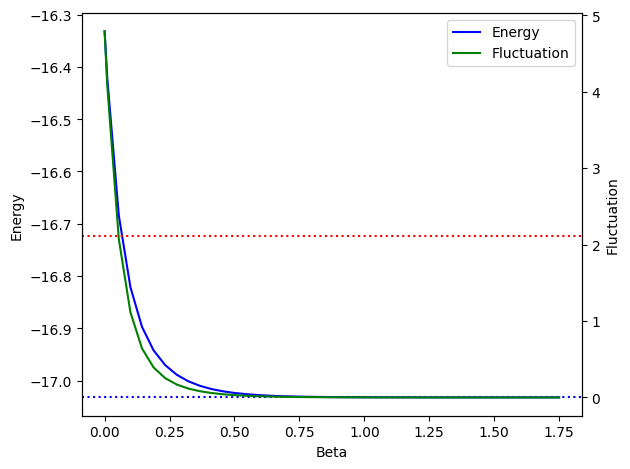

In [10]:
fig, ax1 = plt.subplots()

# 1) Plot energies on the left y-axis
line1, = ax1.plot(beta_list, energies_QITE, label="Energy", color="blue")
ax1.axline((beta_list[0], target), 
           (beta_list[-1], target), 
           linestyle=":", color="blue")
ax1.axline((beta_list[0], first_excited), 
           (beta_list[-1], first_excited), 
           linestyle=":", color="red")
ax1.set_xlabel("Beta")
ax1.set_ylabel("Energy")

# 2) Create a twin axis for fluctuations
ax2 = ax1.twinx()
line2, = ax2.plot(beta_list, fluctuation_QITE, label="Fluctuation", color="green")
ax2.set_ylabel("Fluctuation")

# 3) Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.tight_layout()
plt.show()

# VQE with mannually setup eigenstates

In [11]:
L = 10
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 
# nx.draw(G, with_labels=True)

In [12]:
J = 1
B = 0.5
H = create_heisenberg_hamiltonian(G, J, B)
H_matrix = H.to_array()
print(H)

X(0)*X(1) + X(1)*X(2) + X(2)*X(3) + X(3)*X(4) + X(4)*X(5) + X(5)*X(6) + X(6)*X(7) + X(7)*X(8) + X(8)*X(9) + Y(0)*Y(1) + Y(1)*Y(2) + Y(2)*Y(3) + Y(3)*Y(4) + Y(4)*Y(5) + Y(5)*Y(6) + Y(6)*Y(7) + Y(7)*Y(8) + Y(8)*Y(9) + 0.5*Z(0) + Z(0)*Z(1) + 0.5*Z(1) + Z(1)*Z(2) + 0.5*Z(2) + Z(2)*Z(3) + 0.5*Z(3) + Z(3)*Z(4) + 0.5*Z(4) + Z(4)*Z(5) + 0.5*Z(5) + Z(5)*Z(6) + 0.5*Z(6) + Z(6)*Z(7) + 0.5*Z(7) + Z(7)*Z(8) + 0.5*Z(8) + Z(8)*Z(9) + 0.5*Z(9)


In [13]:
eigvals, eigvecs = np.linalg.eigh(H_matrix)

In [14]:
eigvals, eigvecs = np.linalg.eigh(H_matrix)
idx = np.argsort(eigvals)
eigvals_sorted = eigvals[idx].real
print('Eigen energies:', eigvals_sorted)
eigvecs_sorted = eigvecs[:,idx].T
eigvecs_sorted = [vec.reshape(-1,1) for vec in eigvecs_sorted]

Eigen energies: [-17.03214083 -16.72269436 -15.72269436 ...  12.80422607  13.
  14.        ]


In [15]:
# ground state
psi0 = eigvecs_sorted[0]


In [28]:
beta_list = [0]+np.linspace(0.01,7,60).tolist()

In [33]:
epsilon = 0.001
alpha = 0.5
energy_dict = dict()
fluctuation_dict = dict()
fidelity_dict = dict()
mid_id_ls = [1,2,4]
for mid_id in mid_id_ls:
    results_psi = []
    psi = eigvecs_sorted[10] + alpha*eigvecs_sorted[mid_id] + epsilon*eigvecs_sorted[0]
    psi = psi/np.linalg.norm(psi)
    fidelity_ls = []
    print(np.vdot(psi0, psi))
    initial_moment = compute_moments(psi, H_matrix)
    print(f'|E10>+{alpha}|E{mid_id}>+{epsilon}|E0>:Initial energy {initial_moment[0]}, fluctuation {initial_moment[-1]}')
    for beta in beta_list:
        psi_beta = scipy.linalg.expm(-beta*H_matrix).dot(psi)
        psi_beta = psi_beta / np.linalg.norm(psi_beta)
        fidelity_ls.append(np.vdot(psi0, psi_beta))
        results_psi.append(compute_moments(psi_beta, H_matrix))
    energies_psi = [r[0] for r in results_psi]
    fluctuation_psi = [r[-1] for r in results_psi]
    energy_dict[mid_id]=energies_psi
    fluctuation_dict[mid_id]=fluctuation_psi
    fidelity_dict[mid_id] = fidelity_ls

(0.000894426833229287+0j)
|E10>+0.5|E1>+0.001|E0>:Initial energy -13.831080861623466, fluctuation 2.090367380749285
(0.0008944268332293642+0j)
|E10>+0.5|E2>+0.001|E0>:Initial energy -13.631081021623338, fluctuation 1.0937228115116966
(0.0008944268332292867+0j)
|E10>+0.5|E4>+0.001|E0>:Initial energy -13.431081181623217, fluctuation 0.4170780502742275


# Plot fidelity
Definition of fidelity: 
$$
F(\rho, \sigma) = \left(\text{tr} \sqrt{\sqrt \rho \sigma \sqrt \rho}\right)^2
$$

OR

$$
||\lang \psi| \sigma\rang||^2
$$

In [18]:
def state_to_dm(psi):
    # column vector
    psi = psi.reshape(-1, 1)
    return psi @ psi.conj().T

def fidelity(rho, sigma) -> float:
    sqrt_rho = scipy.linalg.sqrtm(rho)
    return (np.trace(scipy.linalg.sqrtm(sqrt_rho @ sigma @ sqrt_rho)).real)**2

In [19]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

In [20]:
run_param_rc(18)

/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


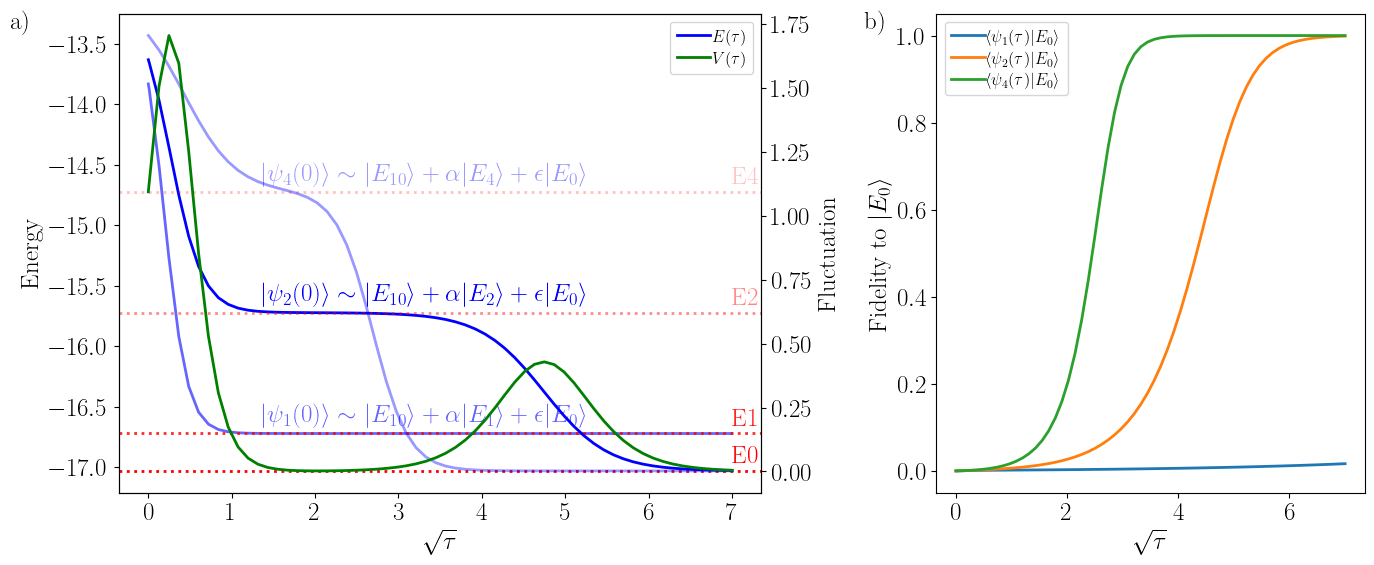

In [ ]:
# Create a figure with 2 subplots side-by-side
fig, (ax_energy, ax_fidelity) = plt.subplots(1, 2, 
                                             figsize=(14, 6),
                                             gridspec_kw={"width_ratios":[1.5,1]})
a = -.17
b = .97
ax_energy.annotate('a)', xy = (a,b), xycoords='axes fraction')
ax_fidelity.annotate('b)', xy = (a,b), xycoords='axes fraction')

###############################################################################
# SUBPLOT 1: Energy + fluctuation (with a twin y-axis)
###############################################################################
ax1 = ax_energy  # rename for clarity

# Plot a horizontal line for the ground-state energy
ax1.axline((beta_list[0], eigvals_sorted[0]), 
           (beta_list[-1], eigvals_sorted[0]), 
           linestyle=":", color="red")
ax1.text(
    beta_list[-1],           # shift text slightly to the right
    eigvals_sorted[0]+0.12,             # same y as the line
    r"$E_0$",                           # label for that line
    va="center",
    ha="left",
    color="red",
)

alphas = [0.6, 1, 0.4]

# Plot energies for each mid_id
for i, mid_id in enumerate(mid_id_ls):
    # Possibly highlight mid_id=2 with a label
    if mid_id == 2:
        line1, = ax1.plot(
            beta_list, 
            energy_dict[mid_id], 
            # label=rf"$\langle \psi^{{{mid_id}}}(\tau)|\hat H|\psi_{{{mid_id}}}(\tau)\rangle$", 
            label=rf"$E(\tau)$",
            color="blue", 
            alpha=alphas[i]
        )
    else:
        line1, = ax1.plot(
            beta_list, 
            energy_dict[mid_id], 
            color="blue", 
            alpha=alphas[i]
        )

    # Annotations on each line (example)
    ax1.text(
        beta_list[-1]/6 + 0.2, 
        eigvals_sorted[mid_id]+0.15,
        rf"$|\psi_{{{mid_id}}}(0)\rangle \sim |E_{{10}}\rangle + \alpha |E_{{{mid_id}}}\rangle + \epsilon |E_0\rangle$",
        va="center",
        ha="left",
        color="blue",
        alpha=alphas[i]
    )

    # Horizontal line for the mid_id'th eigenvalue
    ax1.axline(
        (beta_list[0], eigvals_sorted[mid_id]),
        (beta_list[-1], eigvals_sorted[mid_id]),
        linestyle=":",
        color="red",
        alpha=1.0 / (int(mid_id) + 0.2)
    )

    ax1.text(
        beta_list[-1],
        eigvals_sorted[mid_id] + 0.12,
        f"$E_{mid_id}$",
        va="center",
        ha="left",
        color="red",
        alpha=1.0 / (int(mid_id) + 0.1)
    )

ax1.set_xlabel(r"$\sqrt{\tau}$")
ax1.set_ylabel("Energy")

# Create a twin axis for fluctuation
ax2 = ax1.twinx()
line2, = ax2.plot(
    beta_list, 
    fluctuation_dict[2],
    # label=r"$\langle \psi_2(\tau)|(\hat H-E(\tau))^2|\psi_2(\tau)\rangle$",
    label=r"$V(\tau)$",
    color="green"
)
ax2.set_ylabel("Fluctuation")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

###############################################################################
# SUBPLOT 2: Fidelity to the ground state
###############################################################################
axF = ax_fidelity

# Plot fidelity for each mid_id (example)
for i, mid_id in enumerate(mid_id_ls):
    lineF, = axF.plot(
        beta_list, fidelity_dict[mid_id],
        label=rf"$\langle\psi_{{{mid_id}}}(\tau)|E_0\rangle$",
    )

axF.set_xlabel(r"$\sqrt{\tau}$")
axF.set_ylabel(r"Fidelity to $|E_0\rangle$")

axF.legend(loc="best")

plt.tight_layout()
plt.savefig("plateau_subplots.pdf")
plt.show()